In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from sklearn.metrics import r2_score


import datetime
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from pandas.core.nanops import nanmean as pd_nanmea

output_notebook()

Loading BokehJS ...

<AxesSubplot:xlabel='Date'>

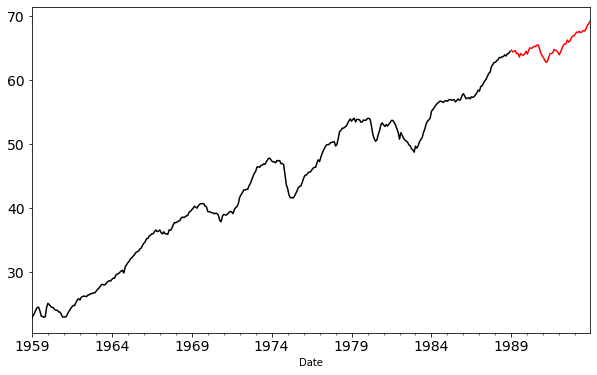

In [61]:
training_data = pd.read_excel('training.xlsx')
date = training_data["Date"]
value = training_data["Value"]
training_data.index  = training_data.Date
training_data = training_data.drop('Date', axis=1)
training_data.sort_values('Date', ascending = True)
training_data.Value.plot( figsize=(10,6), fontsize=14, color = 'black')

testing_data = pd.read_excel('testing.xlsx')
tdate = testing_data["Date"]
tvalue = testing_data["Value"]
testing_data.index  = testing_data.Date
testing_data = testing_data.drop('Date', axis=1)
testing_data.sort_values('Date', ascending = True)
testing_data.Value.plot( figsize=(10,6), fontsize=14, color = 'red')

In [62]:
X_training = pd.read_excel("training.xlsx").values.copy()
X_testing  = pd.read_excel("testing.xlsx").values.copy()

In [63]:
p = figure(title = 'Data', x_axis_label = 'date', y_axis_label = 'value', x_axis_type='datetime', width = 1000)
p.line(date, value, color = 'black')
p.line(date, value.rolling(30, center = True).mean(), color = 'red')
p.line(date, value.rolling(5, center = True).std(), color = 'purple')

GlyphRenderer(id='5430', ...)

In [64]:
show(p)

In [65]:
d = figure(title = 'Data', x_axis_label = 'date', x_axis_type='datetime', width = 1000)
difference = training_data.Value.shift(-1)-training_data.Value

d.line(date, difference, color = 'black',  width = 1)
d.line(date, difference.rolling(30, center=True).mean(), color = 'red', width = 3)
show(d)

In [66]:
decompos = sm.tsa.seasonal_decompose(training_data.Value, model="additive")

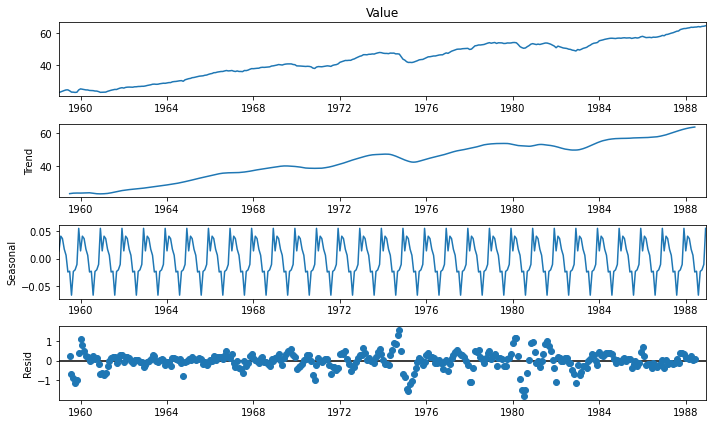

In [78]:
#Аддитивная модель
rcParams['figure.figsize'] = 10, 6
decompos = sm.tsa.seasonal_decompose(training_data.Value, model="additive")
decompos.plot()
plt.show()

In [79]:
print('Аддитивный ренд:')
decompos.trend.dropna(inplace=True)
sm.tsa.stattools.adfuller(decompos.trend)

Аддитивный ренд:


(-0.8615760333583731,
 0.8003625761532325,
 17,
 330,
 {'1%': -3.4503224123605194,
  '5%': -2.870338478726661,
  '10%': -2.571457612488522},
 -1668.5476369136265)

In [80]:
print('Аддитивная сезонность:')
decompos.seasonal.dropna()
sm.tsa.stattools.adfuller(decompos.seasonal)

Аддитивная сезонность:


(-202126365798180.75,
 0.0,
 11,
 348,
 {'1%': -3.4492815848836296,
  '5%': -2.8698813715275406,
  '10%': -2.5712138845950587},
 -24605.28767346336)

In [81]:
print('Остаток:')
decompos.resid.dropna(inplace=True)
sm.tsa.stattools.adfuller(decompos.resid)

Остаток:


(-7.485563833765426,
 4.649096674694056e-11,
 5,
 342,
 {'1%': -3.4496162602188187,
  '5%': -2.870028369720798,
  '10%': -2.5712922615505627},
 57.92953961355761)

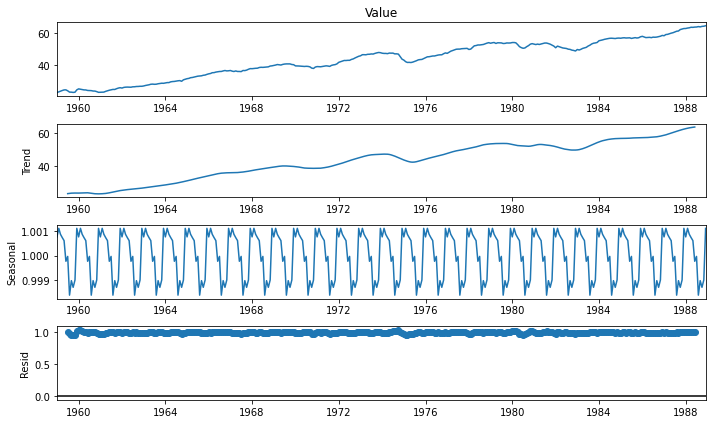

In [82]:
decompos = sm.tsa.seasonal_decompose(training_data.Value, model="multiplicate")
decompos.plot()
plt.show()

In [83]:
print('Мультипликативный тренд:')
decompos.trend.dropna(inplace=True)
adfuller(decompos.trend)

Мультипликативный тренд:


(-0.8615760333583731,
 0.8003625761532325,
 17,
 330,
 {'1%': -3.4503224123605194,
  '5%': -2.870338478726661,
  '10%': -2.571457612488522},
 -1668.5476369136265)

In [84]:
print('Мультипликативная сезонность:')
decompos.seasonal.dropna()
adfuller(decompos.seasonal)

Мультипликативная сезонность:


(-89091918565650.4,
 0.0,
 17,
 342,
 {'1%': -3.4496162602188187,
  '5%': -2.870028369720798,
  '10%': -2.5712922615505627},
 -24936.447573017602)

In [85]:
print('Мультипликативный остаток:')
decompos.resid.dropna(inplace=True)
adfuller(decompos.resid)

Мультипликативный остаток:


(-7.466083739784919,
 5.200193898334382e-11,
 5,
 342,
 {'1%': -3.4496162602188187,
  '5%': -2.870028369720798,
  '10%': -2.5712922615505627},
 -2440.5372728859984)

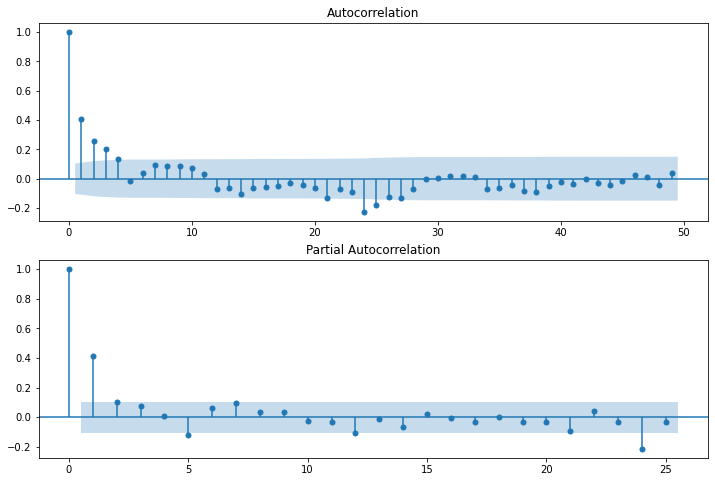

In [86]:
adfuller(training_data.Value)

#построим автокорреляцию и частичную автокорреляцию ряда
traindiff = training_data.Value.diff(periods=1).dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(traindiff.values.squeeze(), lags=49, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(traindiff, lags=25, ax=ax2)


In [87]:
def arima(train, order, test):
    ar = figure(title = 'Data', x_axis_label = 'date', x_axis_type='datetime', width = 1000)
    
    model = sm.tsa.ARIMA(training_data.Value, order=order, freq='MS').fit()
    y_r = model.predict(start = training_data.shape[0], end = training_data.shape[0] + testing_data.shape[0]-1)
    
    ar.line(date, value, color = 'black')
    ar.line(tdate, tvalue, color = 'red')
    ar.line(testing_data.index, y_r, color = 'green')
    print("r2: ", r2_score(testing_data.Value, y_r))
    show(ar)


In [88]:
arima(training_data, (1,0,3), testing_data)

r2:  -0.4719151104791579
